In [36]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

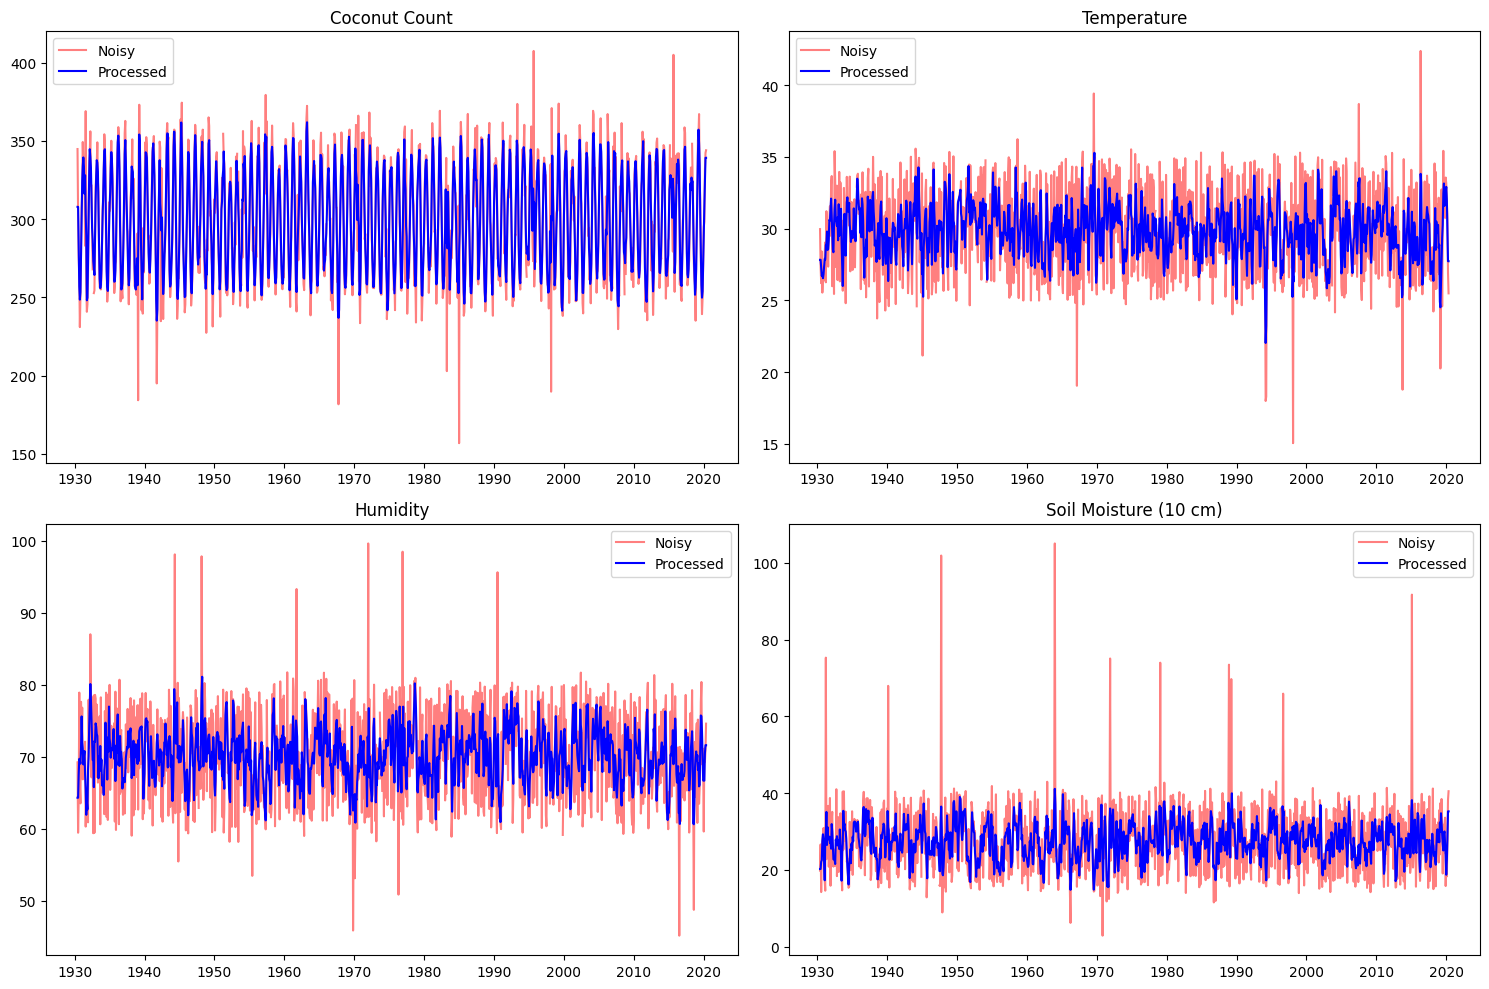


Summary Statistics - Before Preprocessing:
                      Date  Soil Moisture (10 cm) (%)  \
count                 1080                1070.000000   
mean   1975-05-16 09:24:00                  27.732086   
min    1930-05-31 00:00:00                   2.875366   
25%    1952-11-22 12:00:00                  20.940349   
50%    1975-05-15 12:00:00                  27.411528   
75%    1997-11-07 12:00:00                  33.616563   
max    2020-04-30 00:00:00                 105.039490   
std                    NaN                   9.162781   

       Soil Moisture (20 cm) (%)  Soil Moisture (30 cm) (%)  \
count                1070.000000                1070.000000   
mean                   35.394840                  42.563668   
min                     3.855704                   0.937008   
25%                    27.059351                  33.565534   
50%                    34.973089                  42.328534   
75%                    42.821580                  50.906955   
m

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
import matplotlib.pyplot as plt

# Load noisy data
df_noisy = pd.read_csv('noisy_coconut_data.csv', parse_dates=['Date'])

# Preprocessing function
def preprocess_data(df):
   df_processed = df.copy()
   
   # Handle missing values
   numeric_columns = df.select_dtypes(include=[np.number]).columns
   for col in numeric_columns:
       df_processed[col] = df_processed[col].fillna(df_processed[col].median())
   
   # Remove outliers using IQR method
   for col in numeric_columns:
       if col != 'Rain Status (0/1)':  
           Q1 = df_processed[col].quantile(0.25)
           Q3 = df_processed[col].quantile(0.75)
           IQR = Q3 - Q1
           lower_bound = Q1 - 1.5 * IQR
           upper_bound = Q3 + 1.5 * IQR
           df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)
   
   # Ensure values are within realistic ranges
   df_processed['Soil Moisture (10 cm) (%)'] = df_processed['Soil Moisture (10 cm) (%)'].clip(0, 100)
   df_processed['Soil Moisture (20 cm) (%)'] = df_processed['Soil Moisture (20 cm) (%)'].clip(0, 100)
   df_processed['Soil Moisture (30 cm) (%)'] = df_processed['Soil Moisture (30 cm) (%)'].clip(0, 100)
   df_processed['Temperature (°C)'] = df_processed['Temperature (°C)'].clip(20, 40)
   df_processed['Humidity (%)'] = df_processed['Humidity (%)'].clip(0, 100)
   df_processed['Rainfall (mm)'] = df_processed['Rainfall (mm)'].clip(0, None)
   df_processed['Coconut Count'] = df_processed['Coconut Count'].clip(200, 400)
   
   # Apply smoothing using rolling mean
   window_size = 3
   for col in numeric_columns:
       if col not in ['Rain Status (0/1)', 'Plant Age (years)']:
           df_processed[col] = df_processed[col].rolling(window=window_size, center=True).mean()
   
   # Fill NaN values created by rolling mean
   df_processed = df_processed.fillna(method='bfill').fillna(method='ffill')
   
   return df_processed

# Apply preprocessing
df_processed = preprocess_data(df_noisy)

# Create visualization of before and after preprocessing
plt.figure(figsize=(15, 10))

# Plot for Coconut Count
plt.subplot(2, 2, 1)
plt.plot(df_noisy['Date'], df_noisy['Coconut Count'], 'r-', alpha=0.5, label='Noisy')
plt.plot(df_processed['Date'], df_processed['Coconut Count'], 'b-', label='Processed')
plt.title('Coconut Count')
plt.legend()

# Plot for Temperature
plt.subplot(2, 2, 2)
plt.plot(df_noisy['Date'], df_noisy['Temperature (°C)'], 'r-', alpha=0.5, label='Noisy')
plt.plot(df_processed['Date'], df_processed['Temperature (°C)'], 'b-', label='Processed')
plt.title('Temperature')
plt.legend()

# Plot for Humidity
plt.subplot(2, 2, 3)
plt.plot(df_noisy['Date'], df_noisy['Humidity (%)'], 'r-', alpha=0.5, label='Noisy')
plt.plot(df_processed['Date'], df_processed['Humidity (%)'], 'b-', label='Processed')
plt.title('Humidity')
plt.legend()

# Plot for Soil Moisture
plt.subplot(2, 2, 4)
plt.plot(df_noisy['Date'], df_noisy['Soil Moisture (10 cm) (%)'], 'r-', alpha=0.5, label='Noisy')
plt.plot(df_processed['Date'], df_processed['Soil Moisture (10 cm) (%)'], 'b-', label='Processed')
plt.title('Soil Moisture (10 cm)')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics - Before Preprocessing:")
print(df_noisy.describe())
print("\nSummary Statistics - After Preprocessing:")
print(df_processed.describe())

# Print missing values information
print("\nMissing Values - Before Preprocessing:")
print(df_noisy.isnull().sum())
print("\nMissing Values - After Preprocessing:")
print(df_processed.isnull().sum())

# Save processed data
df_processed.to_csv('processed_coconut_data.csv', index=False)
print("\nProcessed data saved to 'processed_coconut_data.csv'")

In [38]:
# Load the dataset
# df = pd.read_csv('seasonal_coconut_yield_data_4.csv', parse_dates=['Date'], index_col='Date')
df = pd.read_csv('processed_coconut_data.csv', parse_dates=['Date'], index_col='Date')
df_before = pd.read_csv('noisy_coconut_data.csv', parse_dates=['Date'],  index_col='Date')

In [39]:
df.head(2)


,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Coconut Count
Date,,,,,,,,,
1930-05-31,20.23136,31.033891,41.227105,5,27.823293,64.297799,5.281903,1,307.90744
1930-06-30,20.23136,31.033891,41.227105,4,27.823293,64.297799,5.281903,1,307.90744


In [40]:
df_before.head(2)

,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Coconut Count
Date,,,,,,,,,
1930-05-31,19.828355,23.811809,NaN,5,29.962130,69.211172,12.463287,1,344.863742
1930-06-30,26.631975,46.461767,43.276778,4,27.318187,59.439589,6.849594,1,302.545563


In [41]:
train_size = int(len(df) * 0.8)
train = df['Coconut Count'][:train_size]
test = df['Coconut Count'][train_size:]

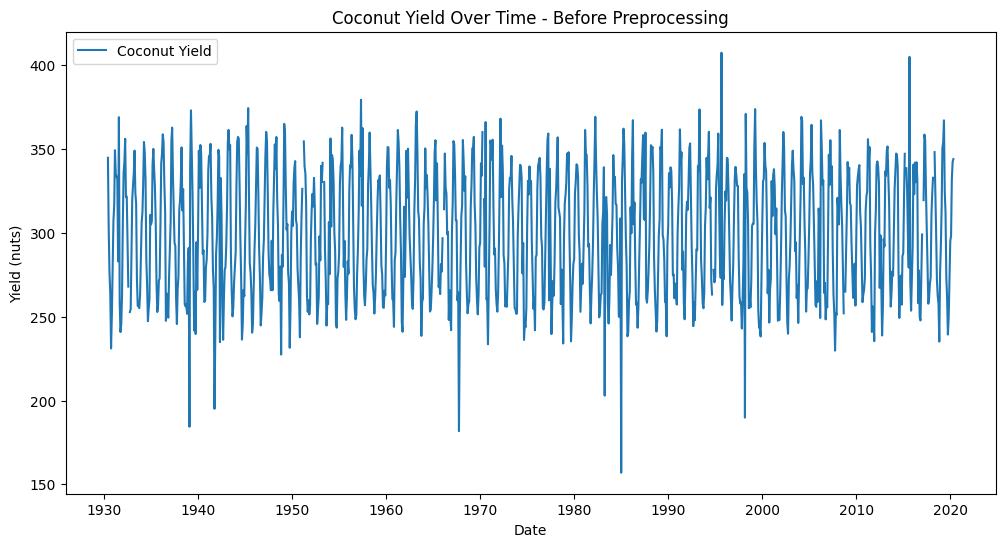

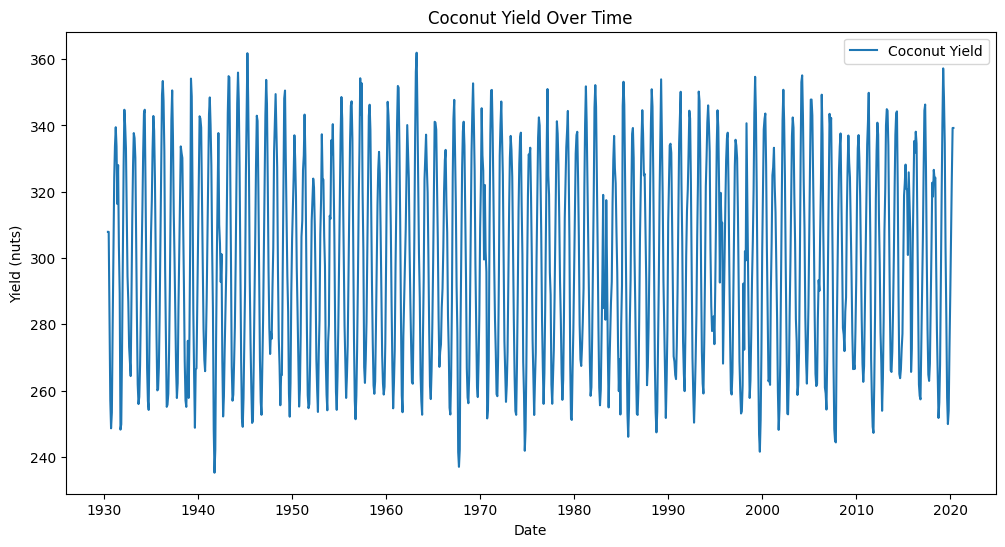

In [42]:
# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_before['Coconut Count'], label='Coconut Yield')
plt.title('Coconut Yield Over Time - Before Preprocessing')
plt.xlabel('Date')
plt.ylabel('Yield (nuts)')
plt.legend()
plt.show()

# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(df['Coconut Count'], label='Coconut Yield')
plt.title('Coconut Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Yield (nuts)')
plt.legend()
plt.show()

In [43]:
# Test for stationarity (ADF test)
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

In [44]:
test_stationarity(df['Coconut Count'])

ADF Statistic: -6.8578355211751045
p-value: 1.6311339603189238e-09


In [45]:
def train_evaluate_model(model_name, train, test):
    if model_name == 'ARIMA':
        auto_model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
        model = ARIMA(train, order=auto_model.order)
        fitted = model.fit()
        forecast = fitted.forecast(steps=len(test))
        fitted_model = fitted
        
    elif model_name == 'Holt-Winters':
        model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
        fitted = model.fit()
        forecast = fitted.forecast(len(test))
        fitted_model = fitted
        
    elif model_name == 'SARIMA':
        model = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
        fitted = model.fit()
        forecast = fitted.forecast(steps=len(test))
        fitted_model = fitted
    
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    accuracy = 100 * (1 - rmse/np.mean(test))
    
    return fitted_model, forecast, {'MAE': mae, 'RMSE': rmse, 'Accuracy': accuracy}

In [46]:
models = ['ARIMA', 'Holt-Winters', 'SARIMA']
results = {}
best_accuracy = -np.inf
best_model = None

for model_name in models:
    model, forecast, metrics = train_evaluate_model(model_name, train, test)
    results[model_name] = {'model': model, 'forecast': forecast, 'metrics': metrics}
    
    if metrics['Accuracy'] > best_accuracy:
        best_accuracy = metrics['Accuracy']
        best_model = model_name

c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

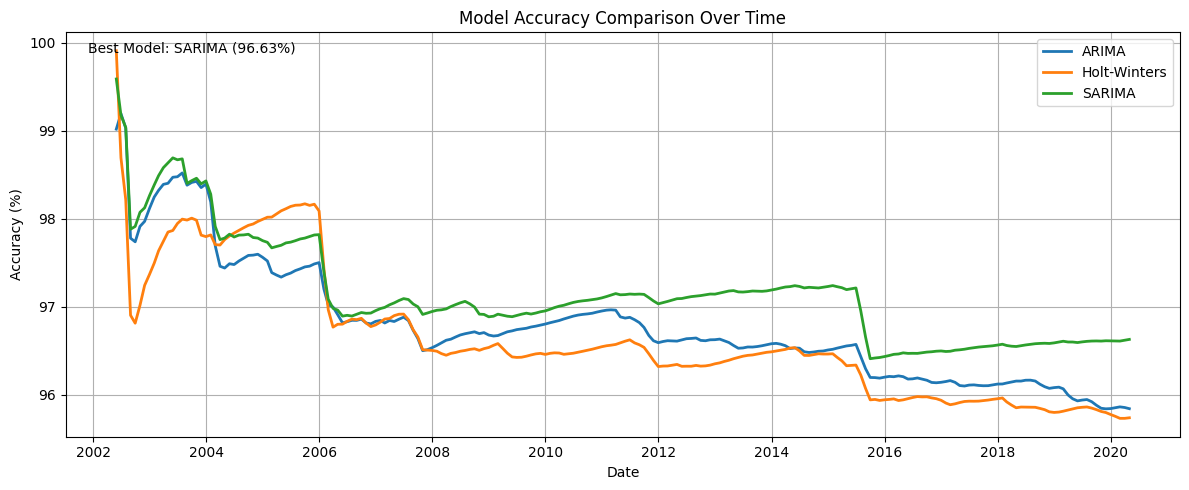

Best Model: SARIMA (96.63%)


In [54]:
def plot_time_series_accuracies(models, train, test):
   plt.figure(figsize=(12, 5))
   
   for model_name, result in results.items():
       forecast = result['forecast']
       accuracies = []
       
       for t in range(1, len(test) + 1):
           actual = test[:t]
           pred = forecast[:t]
           accuracy = 100 * (1 - np.sqrt(mean_squared_error(actual, pred)) / np.mean(actual))
           accuracies.append(accuracy)
       
       plt.plot(test.index, accuracies, '-', linewidth=2, label=f'{model_name}')
   
   plt.title('Model Accuracy Comparison Over Time')
   plt.xlabel('Date')
   plt.ylabel('Accuracy (%)')
   plt.legend()
   plt.grid(True)
   
   # Add annotation for best model
   plt.annotate(f'Best Model: {best_model} ({best_accuracy:.2f}%)',
               xy=(0.02, 0.95), xycoords='axes fraction')

   plt.tight_layout()
   plt.show()

# Plot accuracies
plot_time_series_accuracies(models, train, test)

# Print summary
print(f"Best Model: {best_model} ({best_accuracy:.2f}%)")

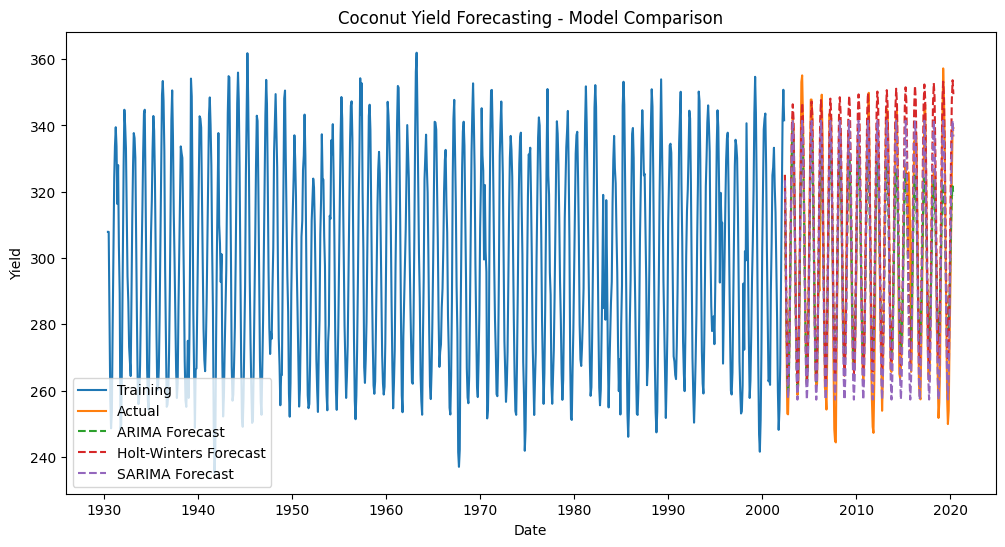

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
for model_name, result in results.items():
    plt.plot(test.index, result['forecast'], label=f'{model_name} Forecast', linestyle='--')
plt.title('Coconut Yield Forecasting - Model Comparison')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [49]:
future_steps = 6
if best_model == 'ARIMA' or best_model == 'SARIMA':
    best_forecast = results[best_model]['model'].forecast(steps=future_steps)
elif best_model == 'Holt-Winters':
    best_forecast = results[best_model]['model'].forecast(future_steps)

future_dates = pd.date_range(start=test.index[-1], periods=future_steps+1, freq='M')[1:]
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Yield': best_forecast
})

print("\nNext 6 months predictions:")
print(forecast_df)


Next 6 months predictions:
                 Date  Predicted_Yield
2002-05-31 2020-05-31       323.462886
2002-06-30 2020-06-30       302.220647
2002-07-31 2020-07-31       279.844534
2002-08-31 2020-08-31       264.187990
2002-09-30 2020-09-30       257.636282
2002-10-31 2020-10-31       263.599767
